# Gaia Objects in the Vicinty of Alpha-Persei

In [1]:
import astropy.coordinates as coord
from astropy.table import QTable, vstack

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pandas as pd
import pickle
import os

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

In [3]:
from cluster import cluster as cl
from fieldstars import fieldstars as fs

In [4]:
alpha_per_lodieu = cl('alpha_per','./data/J_A+A_628_A66')

In [5]:
#column mapper to map to field star class
colmapper= {'source_id':'SourceCP', 'ra':'RAdeg', 'dec':'DEdeg','parallax':'Plx',
            'pmra':'pmRA', 'pmdec':'pmDE', 'radial_velocity':'RVCP',
            'phot_g_mean_mag':'Gmag', 'phot_bp_mean_mag':'BPmag', 'phot_rp_mean_mag':'RPmag','r_est':'rest'}

In [15]:
from fieldstars import from_pandas, from_pickle
alpha_per=from_pandas(alpha_per_lodieu.objs, colmapper, name='lodieu')

alpha_per.objs.head()

In [8]:
len(alpha_per.objs),(alpha_per.objs.radial_velocity != -9999.0).sum()

(3162, 168)

In [9]:
len(alpha_per.objs),(alpha_per.objs.r_est != -9999.0).sum()

(3162, 3162)

In [10]:
alpha_per_lodieu.findcolumns('distance')

[('distC', 'Distance from the center of the cluster (dist_center)'),
 ('rest', 'Estimated distance (r_est)'),
 ('b_rest',
  'Lower bound on the confidence interval of the estimated distance (r_lo)'),
 ('B_rest',
  'Upper bound on the confidence interval of the estimated distance (r_hi)'),
 ('rlen',
  'Length scale used in the prior for the distance estimation (r_len)'),
 ('angDist1', '? Distance to Gaia DR2 source (angDist_1)'),
 ('angdist2MASS', '? Angular distance to 2MASS source (angdist_tmass)'),
 ('angDistW', '? Angular distance to WISE source (angdist_wise)'),
 ('angdistSDSS', '? angular distance to SDSS source (angdist_sdss)'),
 ('angdistPS1', '? angular distance to PS1 source (angdist_ps1)'),
 ('angDist_2', '? Angular distance to Simbad source (angDist_2)'),
 ('angdistGSC9', '? Angular distance to GSC9 source (angdist_gsc9)')]

In [11]:
alpha_per_lodieu.coldefs['rest']

{'units': 'pc', 'desc': 'Estimated distance (r_est)'}

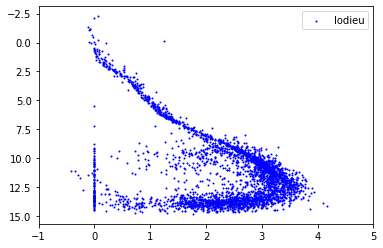

In [12]:
alpha_per.plot_hrdiagram()

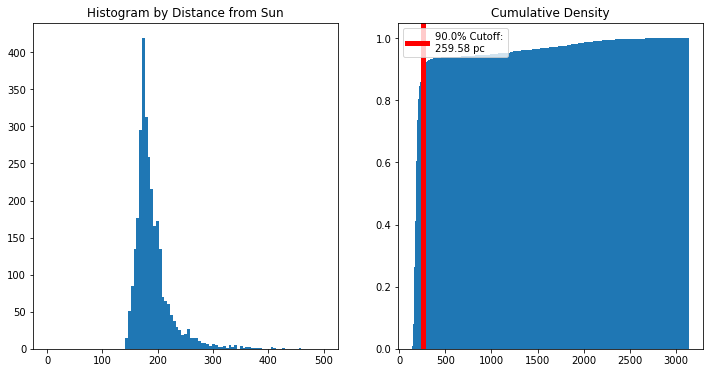

In [13]:
cutpt = 0.90

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
zz=ax[0].hist(alpha_per.objs.r_est,bins=np.linspace(0,500,100))
ax[0].set_title('Histogram by Distance from Sun')
cumpct, bins, recs =ax[1].hist(alpha_per.objs.r_est,bins=500,cumulative=True,density=True)
ax[1].set_title('Cumulative Density')
# get 90% cut off
bin_cut = np.arange(len(cumpct))[cumpct>cutpt][0]
# nid point of the bin
cut_val = (bins[bin_cut]+bins[bin_cut+1])/2
legendstr=f'{cutpt*100.0}% Cutoff:\n{cut_val:.2f} pc'
ax[1].axvline(cut_val,color='red',lw=5, label=legendstr)
ax[1].legend()

In [14]:
# center of the observations:
ra = alpha_per.objs.ra.mean(); dec = alpha_per.objs.dec.mean()


search_r = alpha_per.maxsep()
#search_r=17.6246967327452*u.degree

#distance constraint (10% on either side of median):
med_dist = cut_val

print(f'Search cone: ra: {ra}, dec: {dec}, search radius: {search_r}')
print(f'Distance constraint: between {med_dist*0.5} and {med_dist}')

Search cone: ra: 52.074625695066345, dec: 48.932707471347136, search radius: 11.462475027258863 deg
Distance constraint: between 129.79220449999997 and 259.58440899999994


In [18]:
import pickle
v_name = 'alpha_per_vicinity'
v_path = os.path.join('./data',v_name+'.pkl')

if os.path.exists(v_path):
    print(f'reading pickle: {v_path}')
    alpha_per_vicinity = from_pickle(v_path)
else:
    print('Cone Search Query')
    alpha_per_vicinity=fs(name = v_name)
    alpha_per_vicinity.conesearch(ra*u.degree, dec*u.degree, search_r, name='alpha_per_vicinity',
                           r_est= (med_dist*0.5, med_dist),maxrec=1000000,plx_error_thresh=5)
    alpha_per_vicinity.to_pickle(v_path)
    
print(f'{alpha_per_vicinity.name} contains {len(alpha_per_vicinity.objs)} objs')

reading pickle: ./data/alpha_per_vicinity.pkl
alpha_per_vicinity contains 47399 objs


In [19]:
consol_fs = alpha_per_vicinity.merge(alpha_per)
consol_fs.objs._merge.value_counts()

left_only     45112
both           2287
right_only      875
Name: _merge, dtype: int64

In [20]:
consol_fs.tap_query_string

["SELECT \n\t\t source_id\n\t\t,ra\n\t\t,dec\n\t\t,parallax\n\t\t,pmra\n\t\t,pmdec\n\t\t,radial_velocity\n\t\t,phot_g_mean_mag\n\t\t,phot_bp_mean_mag\n\t\t,phot_rp_mean_mag\n\t\t,r_est\nFROM gaiadr2_complements.geometric_distance gd\n\tINNER JOIN gaiadr2.gaia_source gs using (source_id) \nWHERE \n\tCONTAINS(POINT('', gs.ra, gs.dec), \n\t\tCIRCLE('', 52.074625695066345, 48.932707471347136, 11.462475027258863)) = 1 \n\tAND gd.r_est BETWEEN 129.79220449999997 AND 259.58440899999994\n\tAND parallax_over_error >= 5",
 None]

In [21]:
consol_fs.name

'alpha_per_vicinity merged with lodieu'

Text(0.5, 0.98, 'alpha_per_vicinity merged with lodieu')

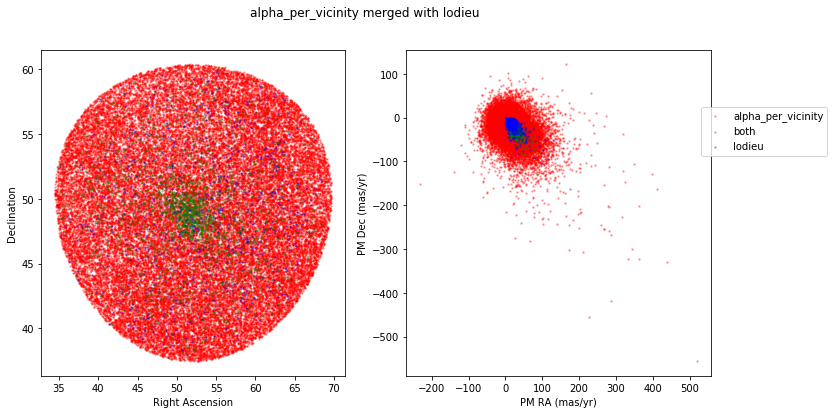

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for s,c in zip(['alpha_per_vicinity','both','lodieu',],['red','green','blue']):
  pdf = consol_fs.objs.query('which == @s')
  ax[0].scatter(pdf.ra, pdf.dec, color=c, label=s, s=2, alpha=0.3)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for s,c in zip(['alpha_per_vicinity','both','lodieu'],['red','green','blue']):
  pdf = consol_fs.objs.query('which == @s')
  ax[1].scatter(pdf.pmra, pdf.pmdec, color=c, label=s, s=2, alpha=0.3)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')

fig.suptitle(consol_fs.name)

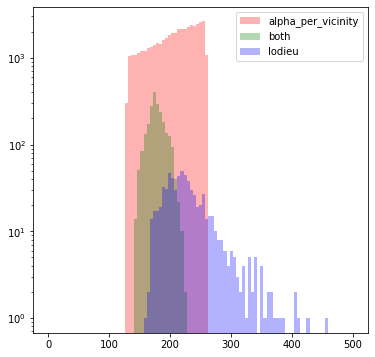

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for s,c in zip(['alpha_per_vicinity','both','lodieu',],['red','green','blue']):
  pdf = consol_fs.objs.query('which == @s')
  ax.set_yscale('log')
  ax.hist(pdf.r_est,bins=np.linspace(0,500,100, endpoint=True), color=c, label=s,  alpha=0.3)
ax.legend()